In [7]:
from lbmpy.methods.creationfunctions import createSRT
from lbmpy.methods.momentbasedsimplifications import *
from lbmpy.stencils import getStencil, visualizeStencil3DBySlicing
import sympy as sp
import numpy as np

from sympy.abc import x, y, z
from functools import partial
import matplotlib.pyplot as plt

sp.init_printing()

%matplotlib inline

def plotSympyFunction(f, bounds, **kwargs):
    xArr = np.linspace(bounds[0], bounds[1], 101)
    yArr = sp.lambdify(x, f)(xArr)
    plt.plot(xArr, yArr, **kwargs)

$$
\newcommand{\bTens}[2]{ \pmb{#1}^{(#2)} }
\newcommand{\bTensS}[3]{ \pmb{#1}^{(#2)}_{\pmb{#3}} }
\newcommand{\bx}[0]{\textbf{x}}
$$

# Construction by cont. Maxwell Boltzmann Distribution

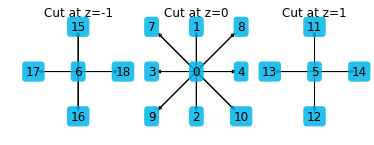

In [8]:
stencil = getStencil("D3Q19")
visualizeStencil3DBySlicing(stencil)

In [9]:
params = { 'compressible': False,
           'equilibriumAccuracyOrder': 2,
           'relaxationRate': sp.Symbol("omega")
         }
sym = sp.Symbol("c_s2")
val13 = sp.Rational(1,3)
old = createSRT(stencil,useContinuousMaxwellianEquilibrium=False, c_s_sq=val13, **params)
new = createSRT(stencil,useContinuousMaxwellianEquilibrium=True, c_s_sq=val13, **params)

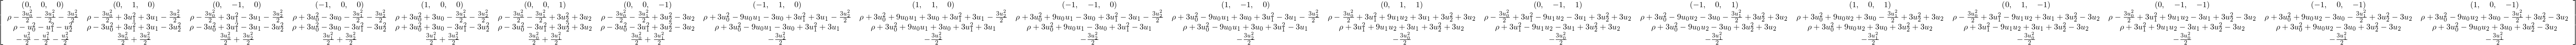

In [10]:
weights = old.weights
oldEq = [sp.expand(e.rhs / w ) for e, w in zip(old.getEquilibrium().mainEquations, weights)]
newEq = [sp.expand(e.rhs / w ) for e, w in zip(new.getEquilibrium().mainEquations, weights)]
diff = [sp.expand(a - b).collect(sp.Symbol("u_0")) for a, b in zip(oldEq, newEq)]
sp.Matrix([stencil, oldEq, newEq, diff])

Direct Neighbors:
$$ \rho w_i ( 1 - u_\alpha u_\alpha )$$

Next Neighbors:
$$ \rho w_i \left( 1 + 3 u_\alpha c_\alpha - 3 u_\alpha u_\alpha + 6 (u_\alpha c_\alpha )^2 \right)$$

Diagonals:
$$ \rho w_i \left( 1 + 3 u_\alpha c_\alpha + 3 u_\alpha^2 c_\alpha 
                  + \frac{9}{2} (c_\alpha u_\alpha)^2 - \frac{9}{2} u_\alpha^2 c_\alpha      \right) = $$
                  
$$ \rho w_i \left( 1 + 3 u_\alpha c_\alpha - \frac{3}{2} u_\alpha^2 c_\alpha^2
                    + \frac{9}{2} (c_\alpha u_\alpha)^2       \right) $$

In [16]:
def testFormula(stencil):
    result = []
    u = sp.symbols("u_:3")
    ua_ua = sum(e**2 for e in u)
    
    for d in stencil:
        entry = 1 # sp.Symbol("rho") * sp.Symbol("w_i")
        ua_ca = sum(u_i * c_i for u_i, c_i in zip(u, d))
        ua2_ca = sum(u_i**2 * c_i**2 for u_i, c_i in zip(u, d))
        dSum = sum(abs(a) for a in d)
        if dSum == 0:
            entry *= 1 - ua_ua
        elif dSum == 1:
            entry *= (1 + 3 * ua_ca - 3 * ua_ua + 6 * ua_ca**2)
        elif dSum == 2:
            entry *= ( 1 + 3 * ua_ca - sp.Rational(3,2) * ua2_ca + sp.Rational(9,2) * ua_ca**2 )
        result.append(entry.expand())
    return result
test = testFormula(getStencil("D3Q19"))
diff = sp.Matrix(test) - sp.Matrix(newEq)
assert (diff.T * diff)[0] == 0

AssertionError: 

In [17]:
from lbmpy.creationfunctions import createLatticeBoltzmannMethod

In [18]:
compressible=False
eao = 3
mOld = createLatticeBoltzmannMethod(method='srt', stencil='D3Q19', compressible=compressible, 
                                    useContinuousMaxwellianEquilibrium=False, equilibriumAccuracyOrder=eao)
mNew = createLatticeBoltzmannMethod(method='srt', stencil='D3Q19', compressible=compressible, 
                                    useContinuousMaxwellianEquilibrium=True, equilibriumAccuracyOrder=eao)

In [19]:
from lbmpy.methods.creationfunctions import compareMomentBasedLbMethods
compareMomentBasedLbMethods(mOld, mNew, True)

Shared Moment,ref,other,difference
$x^{2} y^{2}$,$\frac{\rho}{9} + \frac{u_{0}^{2}}{3} + \frac{u_{1}^{2}}{3} - \frac{u_{2}^{2}}{6}$,$\frac{\rho}{9} + \frac{u_{0}^{2}}{3} + \frac{u_{1}^{2}}{3}$,$- \frac{u_{2}^{2}}{6}$
$x^{2} y$,$u_{0}^{2} u_{1} - \frac{u_{1} u_{2}^{2}}{2} + \frac{u_{1}}{3}$,$u_{0}^{2} u_{1} + \frac{u_{1}}{3}$,$- \frac{u_{1} u_{2}^{2}}{2}$
$y^{2} z$,$- \frac{u_{0}^{2} u_{2}}{2} + u_{1}^{2} u_{2} + \frac{u_{2}}{3}$,$u_{1}^{2} u_{2} + \frac{u_{2}}{3}$,$- \frac{u_{0}^{2} u_{2}}{2}$
$y^{2} z^{2}$,$\frac{\rho}{9} - \frac{u_{0}^{2}}{6} + \frac{u_{1}^{2}}{3} + \frac{u_{2}^{2}}{3}$,$\frac{\rho}{9} + \frac{u_{1}^{2}}{3} + \frac{u_{2}^{2}}{3}$,$- \frac{u_{0}^{2}}{6}$
$x z^{2}$,$- \frac{u_{0} u_{1}^{2}}{2} + u_{0} u_{2}^{2} + \frac{u_{0}}{3}$,$u_{0} u_{2}^{2} + \frac{u_{0}}{3}$,$- \frac{u_{0} u_{1}^{2}}{2}$
$x^{2} z^{2}$,$\frac{\rho}{9} + \frac{u_{0}^{2}}{3} - \frac{u_{1}^{2}}{6} + \frac{u_{2}^{2}}{3}$,$\frac{\rho}{9} + \frac{u_{0}^{2}}{3} + \frac{u_{2}^{2}}{3}$,$- \frac{u_{1}^{2}}{6}$
$x^{2} z$,$u_{0}^{2} u_{2} - \frac{u_{1}^{2} u_{2}}{2} + \frac{u_{2}}{3}$,$u_{0}^{2} u_{2} + \frac{u_{2}}{3}$,$- \frac{u_{1}^{2} u_{2}}{2}$
$y z^{2}$,$- \frac{u_{0}^{2} u_{1}}{2} + u_{1} u_{2}^{2} + \frac{u_{1}}{3}$,$u_{1} u_{2}^{2} + \frac{u_{1}}{3}$,$- \frac{u_{0}^{2} u_{1}}{2}$
$x y^{2}$,$u_{0} u_{1}^{2} - \frac{u_{0} u_{2}^{2}}{2} + \frac{u_{0}}{3}$,$u_{0} u_{1}^{2} + \frac{u_{0}}{3}$,$- \frac{u_{0} u_{2}^{2}}{2}$


In [20]:
from lbmpy.moments import *
from lbmpy.maxwellian_equilibrium import *
from lbmpy.stencils import getStencil

/local/bauer/code/lbmpy/lbmpy/maxwellian_equilibrium.py:19: UserWarning: Weigths of discrete equilibrium are only valid if c_s^2 = 1/3
  warnings.warn("Weigths of discrete equilibrium are only valid if c_s^2 = 1/3")


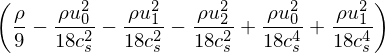

In [21]:
stencil = getStencil("D3Q19")
getMomentsOfDiscreteMaxwellianEquilibrium(stencil, [(2,2,0)], compressible=True)

In [22]:
getMomentsOfContinuousMaxwellianEquilibrium([(2,2,0)],3)

# Equilibrium Construction with Hermite Polynomials


##  What are Hermite polynomials? - Introduction in 1D

To get startet we look at Hermite polynomials in 1D first. The n'th hermite polynomial is defined as

$$ H^{(n)} = (-1)^n \frac{1}{W(x)} \frac{d^n}{dx^n} W(x)  $$
with a weight function $W$, that not coincidentally looks very similar to the Maxwellian distribution.
$$ W(x) = \frac{1}{\sqrt{2\pi}} e ^{-\frac{x^2}{2}}$$

Lets compute the first few Hermite polynomials using this definition. For this the derivative of the weight function is helpful : $\frac{d}{dx} W(x) = -x W(x)$ i.e. differentiating the weight function yields
a factor of $-x$

$$ H^{(0)} = (-1)^0 \frac{1}{W(x)} \frac{d^0}{dx^0} W(x) =  \frac{1}{W(x)} W(x)= 1 $$
$$ H^{(1)} = (-1)^1 \frac{1}{W(x)} \frac{d}{dx} W(x)  = -\frac{1}{W(x)} (-x W(x)) = x$$
$$ H^{(2)} = (-1)^2 \frac{1}{W(x)} \frac{d}{dx} (-x W(x) ) = x^2 - 1 $$

This get tedious really quick, so we implement this definition in *sympy*:

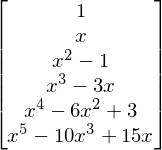

In [23]:
hermiteWeightFunction1D = sp.exp(- x*x / 2) / sp.sqrt(2 * sp.pi)

def hermite1D(n):
    if n == 0: return 1
    W = hermiteWeightFunction1D
    result = (-1)**n * sp.diff(W, *[x] * n) / W
    return result.expand()

# Print the first 6 Hermite polynomials
sp.Matrix([hermite1D(i) for i in range(6)])

In [24]:
from lbmpy.cumulants import cumulantAsFunctionOfRawMoments

#sp.integrate(hermiteWeightFunction1D * x**2, (x, -sp.oo, sp.oo))

Hermite polynomials have an interesting property: they form an ortogonal basis for the space of polynomials with respect to the weighted scalar product

$$ <f, g>_W = \int_{R} f(x) g(x) \; W(x) \; dx .$$

The orthogonality property 
$$ <H^{(n)}, H^{(m)}>_W  = \delta_{nm} \, n! $$
is automatically fulfilled when the polynomials are constructed according to above rule, but can also be used as defining property of the Hermite polynomials.

Note that Hermite polynomials, when defined as above, are not orthonormal. The scalar product of a Hermite polynomial with itself is not equal to one, but to the factorial of its order.

Since Hermite polynomials form a basis, every element of the function space can be expressed as a linear combination of Hermite polynomials. This is analogous to a Taylor or Fourier expansion, where in a Taylor expansion the monomials ($1, x, x^2, x^3, ...$) are used as basis elements and in a Fourier expansion the complex exponentials. We will see that Hermite polynomials are particularly well suited to expand equilibrium distribution functions compared to other bases.

The expanded form of a function $f$ with expansion coefficients $b_i$ is
$$ f(x) = \sum_{n=0}^\infty b_n H^{(n)} $$

Multiplying both sides such that we can reformulate everything as scalar products gives
$$ \int f(x) H^{(m)} W(x) \; dx =  \sum_{n=0}^\infty \int b_n H^{(n)} H^{(m)} W(x) \; dx  \; \Rightarrow \;
 \left<f, H^{(m)} \right>_W  =  \sum_{n=0}^\infty b_n \underbrace{ \left< H^{(n)}, H^{(m)} \right>_W }_{\delta_{nm} n!}   $$

The coefficients can then be determined with
$$ b_n = \frac{1}{n!} \left<f, H^{(n)} \right>_W $$

and the Hermite expansion for an arbitrary function $f$ reads
$$ f(x) = \sum_{n=0}^\infty \frac{1}{n!} \left<f, H^{(n)}\right>_W \, H^{(n)} $$

#### Adapted expansion

In the lattice Boltzmann literature a slightly different expansion is used. There the weight function and normalization factor is moved into the expansion, such that the coefficients are simply the integral over the product of basis function with $f$.

With the expansion formula:

$$ f(x) = W(x) \sum_{n=0}^\infty \frac{1}{n!} a_n H^{(n)} (x) $$

the coefficients simplify to

$$ a_n = \int H^{(n)} f \; dx $$

Since $H^{(n)}$ is a polynomial (i.e. a sum of monomials), the $a_n$ are a linear combination of moments of $f$.

#### Testing expansion

To illustrate the expansion we implemented above formulas for coefficient calculation and for the expansion itself.

In [25]:
def hermiteCoefficient(f, n):
    return sp.integrate( hermite1D(n) * f, (x,-sp.oo, sp.oo) )

def hermiteApproximation(f, N):
    W = hermiteWeightFunction1D
    return W * sum(hermiteCoefficient(f, n) / sp.factorial(n) * hermite1D(n)
                   for n in range(N))

To compute expansion coefficients the integral has to be evaluated from $-\infty$ to $\infty$. Thus only functions where this integral has a definite value can be approximated.

For demonstration, lets approximate the hat function:

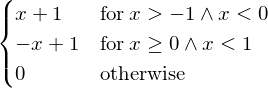

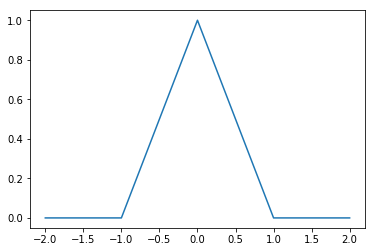

In [26]:
hat = sp.Piecewise((x+1, sp.And(x < 0 , x > -1) ), 
                   (-x+1, sp.And(x >= 0 , x < 1) ), 
                   (0, True))
plotSympyFunction(hat, (-2, 2))
hat

In [27]:
from ipywidgets import interact, IntSlider, FloatSlider
from IPython.display import display

def approximateHat(n):
    approximation = hermiteApproximation(hat, n)
    display(approximation)
    plotSympyFunction(hat, (-2, 2), label='original')
    plotSympyFunction(approximation, (-2, 2), label='approx. n=%d' % (n,))
    plt.legend()
    plt.show()
    
interact(approximateHat, n=IntSlider(min=1,max=16,step=1,value=4));

One can see that indeed the function is approximated, however not particularly well. 
Lets try another example with a Gaussian, a function the Hermite expansion was designed for

In [28]:
def approximateGaussian(variance=2, mean=0, n=4):
    gaussian = sp.exp(-(x-mean)**2 / variance)
    approximation = hermiteApproximation(gaussian, n)
    #display(approximation)
    plotSympyFunction(gaussian, (-5, 5), label='original')
    plotSympyFunction(approximation, (-5, 5), label='approx')
    plt.legend()
    plt.show()

interact(approximateGaussian, variance=FloatSlider(min=1, max=3, step=0.25),
                              mean = FloatSlider(min=-1, max=1, step=0.2),
                              n=IntSlider(min=1,max=16,step=1,value=4));

### Important property of Hermite expansion: Moment conservation

The moments of an order $N$ Hermite approximation has the same first $N$ moments as the original function. 
The approximation conserves the first moments.

For any polynomial $P(x)$ with a degree not greater than $N$ holds:
$$ \int P(x) W \sum_{n=0}^{N} \frac{1}{n!} \left( \int H^{(n)} f \, dx \right) H^{(n)} \, dx = 
   \int P(x) \, f(x) \, dx$$
On the left hand side is the moment of the Hermite expansion, which is equal to the moment of approximated function $f$.

Proof:

The polynomial can be represented in the Hermite basis as $P(x) = \sum_k c_k H^{(k)}(x)$
Inserting this in the left hand side gives
$$ \int W \sum_{n=0}^{N} \frac{1}{n!} \left( \int H^{(n)} f \, dx \right) H^{(n)} \sum_k c_k H^{(k)} \, dx $$
After regrouping:

$$ \sum_{n=0}^{N} \sum_k c_k \left( \int H^{(n)} f \, dx \right) \frac{1}{n!} \int   W H^{(n)}   H^{(k)} \, dx $$

$$ \sum_{n=0}^{N} \sum_k c_k \left( \int H^{(n)} f \, dx \right) \delta_{kn} $$

$$  \int f \sum_{n=0}^{N} c_n H^{(n)}  \, dx = \int f \; P \, dx  $$

## Multidimensional Hermite polynomials

The weight function for $D$ dimensions is:
$$ \omega(\bx) = \frac{1}{(2\pi)^{D/2} } e ^{-\frac{\bx^2}{2}}$$

$$  \bTens{H}{n}(\bx) = (-1)^n \frac{1}{\omega(\bx)} \bTens{\nabla}{n} \; \omega(\bx)  $$



### Main points

- Boltzmann equation is projected onto hermite subspace
- knowing velocities at stencil = knowing exact expansion coefficients up to order 2
- also the continuous Maxwellian is projected onto Hermite subspace (why?) in paper: "because feq has hermite coefficients up to arbitrary order, and thus the conservation of rho and u don't hold exactly"
- moments up to third order of projected and original Maxwellian agree

# Construction with Hermite Expansion

According to 

*Kinetic theory representation of hydrodynamics:
a way beyond the Navier–Stokes equation, Shan, Yuan, Chen 2005*
[link](https://www.cambridge.org/core/services/aop-cambridge-core/content/view/57B640BEE52716398F6C015BC66D189C/S0022112005008153a.pdf/kinetic_theory_representation_of_hydrodynamics_a_way_beyond_the_navierstokes_equation.pdf)

## Hermite Polynomials

A popular way to construct the discrete lattice Boltzmann equilibrium, is by expanding the Maxwell-Boltzmann distribution in a series of Hermite Polynomials. Hermite Polynomials form an orthogonal polynomial basis for the space of square integrable functions w.r.t to the following weighted scalar product:

$$ \int \omega(\xi) H^{(n)} H^{(k)} \; d\xi = \delta_{nk} n! $$

with the weight function.

$$ \omega(\xi) = \frac{1}{\sqrt{2\pi}} e ^{-\frac{\xi^2}{2}}$$

They can be constructed using the weight function:

$$ H^{(n)} = (-1)^n \frac{1}{\omega(\xi)} \frac{d^n}{d\xi^n} \omega(\xi)  $$

In the next cell the hermite polynomials are defined in *sympy* and a few examples are calculated:

In [29]:
def weightFunction(x):
    if hasattr(x, "__len__"):
        dim = len(x)
        xSq = sum(v**2 for v in x)
    else:
        dim = 1
        xSq = x**2
    
    return sp.exp(-xSq / 2) / ( (2 * sp.pi) ** (sp.Rational(dim,2)) )

def hermite(index, variables):
    """Multidimensional Hermite polynomial."""
    order = len(index)
    if order==0 : return sp.Rational(1,1)
    w = weightFunction(variables)
    diffArgs = [variables[i] for i in index]
    result = (-1) ** order / w * sp.diff(w, *diffArgs)
    return result.expand()

def hermite1D(order, var):
    return hermite([0]*order, [var])

def weightedScalarProd(f1, f2, w, x):
    return sp.integrate(f1 * f2 * w, (x, -sp.oo, sp.oo))

def scalarProd(f1, f2):
    return weightedScalarProd(f1, f2, weightFunction(x), x)

In [30]:
hermite((1,1), sp.symbols("x y"))

Examples:

In [31]:
from IPython.display import display

for i in range(6):
    display( sp.Eq(sp.Symbol("H^{(%d)}" % (i,)),
                  hermite1D(i, x)) )

Orthogonality:

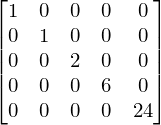

In [32]:
sp.Matrix(5, 5,
          lambda i,j: scalarProd(hermite1D(i, x), hermite1D(j, x)) )

#### Hermite expansion:

A function $f(x)$ can be expanded in Hermite polynomials:

$$ f(\xi) = \omega(\xi) \sum\limits_{n=0}^{\infty} \frac{1}{n!} a^{(n)} H^{(n)}(\xi) $$

with 

$$ a^{(n)} = \int f(\xi) H^{(n)}(\xi) \; d\xi$$

In [33]:
from pystencils.cache import memorycache

@memorycache(maxsize=64)
def hermiteCoeff(f, index, variables):
    intArgs = [(v, -sp.oo, sp.oo) for v in variables]
    result = sp.integrate(hermite(index, variables) * f, *intArgs)
    return result.expand()

@memorycache(maxsize=8)
def hermiteExpansion(order, f, variables):
    from itertools import product
    nrVariables = len(variables)
    
    result = 0
    for currentOrder in range(order):
        termsForOrder = 0
        for index in product(*[range(nrVariables)]*currentOrder):
            termsForOrder += hermiteCoeff(f, index, variables)  * hermite(index, variables)
            print("Order/Index", currentOrder, index, hermiteCoeff(f, index, variables), "   Poly", hermite(index, variables) )

        result += termsForOrder / sp.factorial(currentOrder)
    return result #* weightFunction(variables)

In [34]:
from lbmpy.maxwellian_equilibrium import continuousMaxwellianEquilibrium

variables = sp.symbols("v_:3")
theta = sp.Symbol("theta" ,real=True, positive=True)
mb = continuousMaxwellianEquilibrium(dim=3).subs(sp.Symbol("c_s")**2, theta)

maxwellBoltzmannHermiteApprox = hermiteExpansion(3, mb, variables)

Order/Index 0 () rho    Poly 1
Order/Index 1 (0,) rho*u_0    Poly v_0
Order/Index 1 (1,) rho*u_1    Poly v_1
Order/Index 1 (2,) rho*u_2    Poly v_2
Order/Index 2 (0, 0) rho*theta + rho*u_0**2 - rho    Poly v_0**2 - 1
Order/Index 2 (0, 1) rho*u_0*u_1    Poly v_0*v_1
Order/Index 2 (0, 2) rho*u_0*u_2    Poly v_0*v_2
Order/Index 2 (1, 0) rho*u_0*u_1    Poly v_0*v_1
Order/Index 2 (1, 1) rho*theta + rho*u_1**2 - rho    Poly v_1**2 - 1
Order/Index 2 (1, 2) rho*u_1*u_2    Poly v_1*v_2
Order/Index 2 (2, 0) rho*u_0*u_2    Poly v_0*v_2
Order/Index 2 (2, 1) rho*u_1*u_2    Poly v_1*v_2
Order/Index 2 (2, 2) rho*theta + rho*u_2**2 - rho    Poly v_2**2 - 1


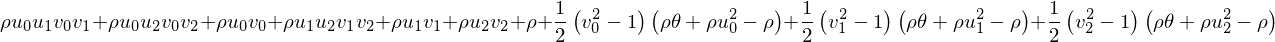

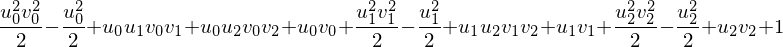

In [35]:
simpl = sp.simplify( maxwellBoltzmannHermiteApprox / sp.Symbol("rho") ).expand().collect(variables)
simpl.subs(theta, 1).expand()

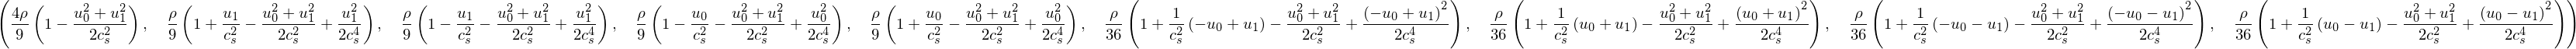

In [36]:
from lbmpy.maxwellian_equilibrium import discreteMaxwellianEquilibrium
from lbmpy.stencils import getStencil
discreteMaxwellianEquilibrium(getStencil('D2Q9'))

In [37]:
from lbmpy.creationfunctions import createLatticeBoltzmannMethod
createLatticeBoltzmannMethod(stencil='D3Q19')

Moment,Eq. Value,Relaxation Rate
$1$,$\rho$,$\omega_{0}$
$x$,$u_{0}$,$\omega_{0}$
$y$,$u_{1}$,$\omega_{0}$
$z$,$u_{2}$,$\omega_{0}$
$x^{2}$,$\frac{\rho}{3} + u_{0}^{2}$,$\omega_{0}$
$y^{2}$,$\frac{\rho}{3} + u_{1}^{2}$,$\omega_{0}$
$z^{2}$,$\frac{\rho}{3} + u_{2}^{2}$,$\omega_{0}$
$x y$,$u_{0} u_{1}$,$\omega_{0}$
$x z$,$u_{0} u_{2}$,$\omega_{0}$
$y z$,$u_{1} u_{2}$,$\omega_{0}$


## Own Subspace construction

In [38]:
from itertools import product
dim = 3
basis = set()
x, y, z = sp.symbols("x y z")
for order in range(3):
    for index in product(*[range(dim)] * order):
        basis.add(hermite(index, [x,y,z]))
basis

In [39]:
additionalVectors = [x**2 * y, x**2 * z, 
                     y**2 * x, y**2 * z,
                     z**2 * x, z**2 * y,
                     x**2 * y**2, x**2 * z**2, y**2 * z**2]
additionalVectors

In [40]:
@memorycache(maxsize=50)
def hermiteScalarProduct3D(f, g):
    weight = weightFunction(x) * weightFunction(y) * weightFunction(z)
    return sp.integrate(weight * f * g, 
                        (x, -sp.oo, sp.oo),
                        (y, -sp.oo, sp.oo),
                        (z, -sp.oo, sp.oo),)

In [ ]:
#basisList = list(basis) + additionalVectors
#sp.Matrix(len(basisList), len(basisList), 
#          lambda i, j: hermiteScalarProduct3D(basisList[i], basisList[j]))

In [45]:
def gramSchmidt(vectors, scalarProduct):
    vecLen = lambda v: sp.sqrt(scalarProduct(v,v))
    projection = lambda u, v: (scalarProduct(u,v) / scalarProduct(u,u)) * u
    result = []
    result.append(vectors[0] / vecLen(vectors[0]))
    
    for newElement in vectors[1:]:
        for r in result:
            newElement -= projection(r, newElement)
        result.append(newElement / vecLen(newElement))
    return result

In [46]:
allVectors = list(basis) + additionalVectors
allVectors

In [47]:
result = gramSchmidt(allVectors, hermiteScalarProduct3D)

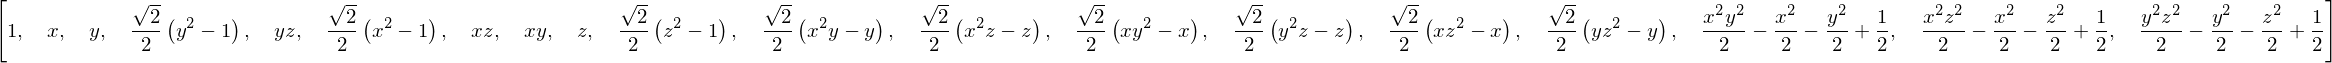

In [48]:
result

In [41]:
#sp.Matrix(len(result), len(result), 
#          lambda i, j: hermiteScalarProduct3D(result[i], result[j]))

In [49]:
from lbmpy.maxwellian_equilibrium import getMomentsOfContinuousMaxwellianEquilibrium

mb = continuousMaxwellianEquilibrium(dim=3).subs(sp.Symbol("c_s")**2, theta)
v = sp.symbols("v_:3")
mbX = mb.subs({v[0]: x, v[1]: y, v[2]: z})


def unweightedScalarProd3D(f, g):
    return sp.integrate(f * g, 
                        (x, -sp.oo, sp.oo),
                        (y, -sp.oo, sp.oo),
                        (z, -sp.oo, sp.oo),)

mbX

myBasis = result

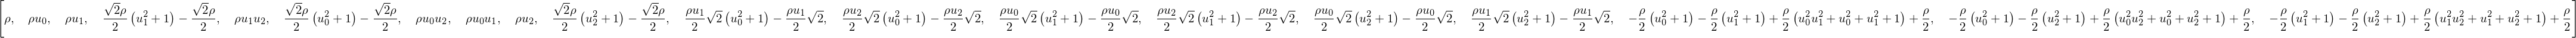

In [57]:
expansionCoefficients = getMomentsOfContinuousMaxwellianEquilibrium(myBasis, dim=3)
expansionCoefficients = [c.subs(sp.Symbol("c_s"), 1) for c in expansionCoefficients]
expansionCoefficients

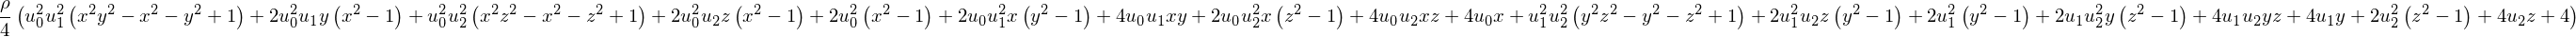

In [61]:
expandedResult = sp.simplify( sum(a* b for a,b in zip(myBasis, expansionCoefficients)) )
expandedResult

In [154]:
def expandedToVector(expansion, truncate2ndOrder=True, addWeights=True):
    d3q19 = getStencil("D3Q19")
    d3q19Weights = getWeights(d3q19, c_s_sq=sp.Rational(1,3))
    expansion = expansion.subs(sp.Symbol("c_s"), 1).subs(theta, 1)
    
    rescaledSymbols = [x,y,z] + list(sp.symbols("u_:3"))
    expansion = expansion.subs({s: s * sp.sqrt(3) for s in rescaledSymbols} )
    
    #expansion = expansion.subs{}
    res = []
    for i in range(len(d3q19)):
        factor = sp.Rational(1,1)
        term = expansion.subs(x,d3q19[i][0]).subs(y,d3q19[i][1]).subs(z,d3q19[i][2])
        if addWeights:
            term *= d3q19Weights[i]
        if truncate2ndOrder:
            term = removeHigherOrderTerms(term.expand())
        res.append(term)
    return sp.Matrix(res)

In [155]:
normalEq = createLatticeBoltzmannMethod(stencil='D3Q19', compressible=True, useContinuousMaxwellianEquilibrium=False).getEquilibriumTerms()
betterEq = createLatticeBoltzmannMethod(stencil='D3Q19', compressible=True, useContinuousMaxwellianEquilibrium=True).getEquilibriumTerms()

Hermite expansion = normal LB equilibrium:

In [156]:
expandedToVector(maxwellBoltzmannHermiteApprox.subs({v[0]: x, v[1]: y, v[2]: z}), truncate2ndOrder=False)- normalEq

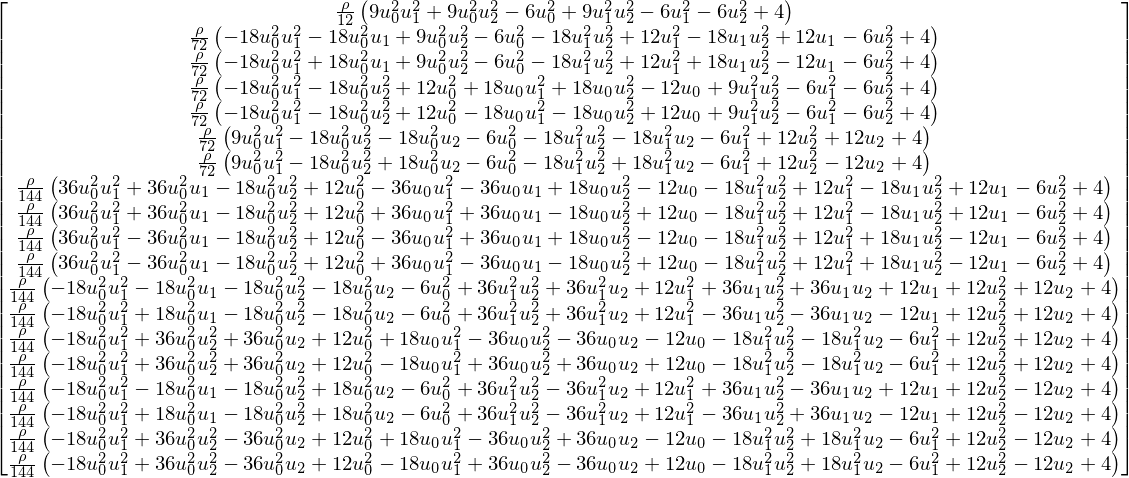

In [158]:
expandedToVector(expandedResult, truncate2ndOrder=False)

## Pointwise evaluation property

In [176]:
from lbmpy.maxwellian_equilibrium import continuousMaxwellianEquilibrium

In [168]:
uVals = (sp.Rational(1,2), sp.Rational(1,3), sp.Rational(1,4))
rhoVal = 1

In [171]:
approx = maxwellBoltzmannHermiteApprox.subs({a:b for a,b in zip(sp.symbols("u_:3"), uVals)}) \
                                      .subs(sp.Symbol("rho"), rhoVal)

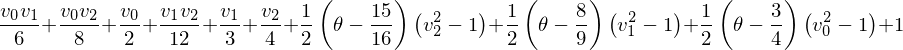

In [172]:
approx

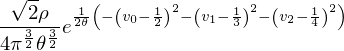

In [177]:
continuousMaxwellianEquilibrium(dim=3, c_s_sq=theta, u = uVals)

MB Approximation again:

In [ ]:
import itertools
from math import factorial
from lbmpy.moments import momentsUpToOrder, momentMultiplicity, MOMENT_SYMBOLS
from lbmpy.maxwellian_equilibrium import *
from lbmpy.stencils import getStencil
from lbmpy.moments import getDefaultMomentSetForStencil, discreteMoment

dim = 3
order = 4
theta = sp.Symbol("theta")
stencil = getStencil("D3Q27")

variables = MOMENT_SYMBOLS[:dim]
x, y, z = MOMENT_SYMBOLS
result = 0
for order_i in range(order+1):
    for index in itertools.product(*[range(dim)]*order_i):
        hermP = hermite(index, variables)
        a_i = getMomentsOfContinuousMaxwellianEquilibrium([hermP], dim=dim,c_s_sq=1)[0]
        result += hermP * a_i / factorial(order_i)

cSym = sp.symbols("c_:3")[:dim]
factorC = sp.sqrt(3)
factorU = sp.sqrt(3)
substitutions = { a: b*factorC for a, b in zip(variables, cSym) } 
substitutions.update( { s: s*factorU for s in sp.symbols("u_:3")} )
substitutions
eq = result.subs(substitutions).expand() 
#( eq / sp.Symbol("rho") ).expand()

In [ ]:
def expandEq(eq, stencil):
    result = []
    weights = getWeights(stencil, c_s_sq=sp.Rational(1,3))
    for w_i, d in zip(weights, stencil):
        result.append( eq.subs( {a: b for a,b in zip(cSym, d)}) * w_i)
    return result

generated = sp.Matrix(expandEq(eq, stencil)).expand()
ref = sp.Matrix(discreteMaxwellianEquilibrium(stencil, c_s_sq=sp.Rational(1,3), order=order)).expand()
diff = generated - ref

In [ ]:
mom = getDefaultMomentSetForStencil(stencil)
contMom = sp.Matrix(getMomentsOfContinuousMaxwellianEquilibrium(mom, dim=dim, c_s_sq=sp.Rational(1,3), order=order))
discMom = sp.Matrix([discreteMoment(tuple(generated), m, stencil) for m in mom])
(contMom - discMom).expand()

In [ ]:
d2q9 = getStencil("D2Q9")
getWeights(d2q9, c_s_sq=sp.Rational(1,3))

## Gauss Quadrature

Gaussian quadrature approximates an integral by:

$$ \int w(x) f(x) \; dx \approx \sum\limits_{a=1}^{n} W_a f(x_a) $$

Where $w(x)$ is the weight function of a scalar product, and the function to integrate is evaluated at the zeros of corresponding orthogonal polynomials. The integration weights $W_a$ are defined as:

$$ W_a = \frac{\left< H^{(n-1)}, H^{(n-1)} \right>_w }  
              {H^{(n-1)}(x_a) \;  \frac{d}{dx} H^{(n)} \rvert_{x_a} }  $$


This approximation is exact if $f$ is a polynomial of degree $(2n-1)$ or less.

Example: 

To approximate the integral $\int w(x) \; x^3 \; dx$, four evaluation points are required i.e. the zeros of the fourth Hermite polynomial.

In [ ]:
hermite4zeros = sp.solve(hermite(4, x))
hermite4zeros

In [ ]:
def gaussIntegrationWeights(polynomial, weightFunction, x, order):
    p_n_minus_1 = polynomial(order-1, x)
    p_n = polynomial(order, x)
    numerator = weightedScalarProd(p_n_minus_1, p_n_minus_1, 
                                   weightFunction(x), x)
    
    evalPoints = sp.solve(p_n)
    weights = [numerator / p_n_minus_1.subs(x, z) / sp.diff(p_n, x).subs(x, z)
               for z in evalPoints]
    weights = [sp.simplify(w) for w in weights]
    return evalPoints, weights

def gaussHermiteQuadrature(f, x, order):
    zeros, intWeights = gaussIntegrationWeights(hermite, weightFunction, x, order)
    return sum([f.subs(x, z) * w
                for w, z in zip(intWeights,zeros)])

List of evaluation points $x_a$ and their weights $W_a$:

In [ ]:
for o in range(1, 4):
    xa, wa = gaussIntegrationWeights(hermite, weightFunction, x, o)
    display([o, xa, wa])

In [ ]:
sp.sqrt(3).evalf()

# Construction via low Mach number expansion

In [ ]:
from lbmpy.maxwellian_equilibrium import continuousMaxwellianEquilibrium

In [ ]:
mb1d = continuousMaxwellianEquilibrium(1)
mb1d